In [1]:
from completeness import *
from mass_function import *

# mass_function_test file:
import astropy.io.fits as fits
import matplotlib.pyplot as plt


In [14]:
# All the objects that is observed in the Sciencegkv catalog, with or without spectroscopic redshift, but no Z and NQ in the columns. this catalog has stars and ambitious objects.
all_sciencegkv_galaxies_raw = fits.open('../Data/GAMA/gkvScienceCatv02/gkvScienceCatv02.fits')[1].data

# the Objects that have Spec-Z, they can be also stars or ambitious. It is a merged catalog of gkvScience and StellarMass.
galaxy_SpecMass_catalog_raw = fits.open('../Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data
print('all_sciencegkv_galaxies_raw:', len(all_sciencegkv_galaxies_raw))
print('galaxy_SpecMass_catalog_raw:' ,len(galaxy_SpecMass_catalog_raw))

all_sciencegkv_galaxies_raw: 2232985
galaxy_SpecMass_catalog_raw: 370116


In [15]:
# Masks
'''
We now start by adopting the magnitude limit of rKiDSDR4 = 19.65 mag, as discussed in Section 2.2, for the
four primary GAMA regions (G09, G12, G15, and G23). This sub-sample contains 205 540 galaxies
if apply NQ>2, then 95.1 percent of the galaxies will have reliable redshift, as Driver said.
this catalog does NOT have: mass but it has: Z, NQ, SC. with these three masks the number of glaxies reduces to 153 601
'''
all_sciencegkv_galaxies_raw_Basic_Masks = (
    (all_sciencegkv_galaxies_raw['Z'] < 0.4) &
    # (all_sciencegkv_galaxies_raw['Z'] != -9.999) &
    # (all_sciencegkv_galaxies_raw['SC'] > 7) &                 # 95% redshift completeness limit for SC 7, and 98% for SC 8
    # (all_sciencegkv_galaxies_raw['NQ'] > 2) &                 # reliable redshift
    (all_sciencegkv_galaxies_raw['uberclass'] == 1) &           # classified as galaxy
    (all_sciencegkv_galaxies_raw['duplicate'] == 0) &           # unique object
    (all_sciencegkv_galaxies_raw['mask'] == False) &
    (all_sciencegkv_galaxies_raw['starmask'] == False) &
        # (all_sciencegkv_galaxies_raw['RAcen'] > 129.0) &
        # (all_sciencegkv_galaxies_raw['RAcen'] < 141.0) &
        # (all_sciencegkv_galaxies_raw['Deccen'] > -2.0) &
        # (all_sciencegkv_galaxies_raw['Deccen'] < 3.0)&
    (all_sciencegkv_galaxies_raw['flux_rt'] >= 5.011928e-05)    # maximum magnitude of 19.65 in r-band
)
all_sciencegkv_galaxies_Basic_Masked = all_sciencegkv_galaxies_raw[all_sciencegkv_galaxies_raw_Basic_Masks]


COMPLETENESS_MASKS = (
    (galaxy_SpecMass_catalog_raw['Z'] < 0.4) & 
    (galaxy_SpecMass_catalog_raw['Z'] != 0 ) &
    # (galaxy_SpecMass_catalog_raw['SC'] > 7) &                 # 95% redshift completeness limit for SC 7, and 98% for SC 8
    (galaxy_SpecMass_catalog_raw['NQ'] > 2) &                   # reliable redshift
    (galaxy_SpecMass_catalog_raw['uberclass'] == 1 ) &          # classified as galaxy
    (galaxy_SpecMass_catalog_raw['duplicate'] == 0) &           # unique object
    (galaxy_SpecMass_catalog_raw['mask'] == False) &
    (galaxy_SpecMass_catalog_raw['starmask'] == False) &
    (galaxy_SpecMass_catalog_raw['flux_rt'] > 5.011928e-05) &  # maximum magnitude of 19.65 in r-band
    (galaxy_SpecMass_catalog_raw['mstar'] > 0)
)
completeness_Masked_of_SpecMass_catalog = galaxy_SpecMass_catalog_raw[COMPLETENESS_MASKS]


'''
We now limit our sample to the nearby Universe by imposing a redshift cutoff of z < 0.4.
'''
MASS_HISTOGRAM_MASKS = (
    (galaxy_SpecMass_catalog_raw['uberclass'] == 1 ) &          # classified as galaxy
    (galaxy_SpecMass_catalog_raw['duplicate'] == 0) &           # unique object
    (galaxy_SpecMass_catalog_raw['mask'] == False) &
    (galaxy_SpecMass_catalog_raw['starmask'] == False) &
    (galaxy_SpecMass_catalog_raw['mstar'] < 10**14) &
    (galaxy_SpecMass_catalog_raw['NQ'] > 2) &
    (galaxy_SpecMass_catalog_raw['Z'] != 0) &
    (galaxy_SpecMass_catalog_raw['Z'] < 0.4) &
    # (galaxy_SpecMass_catalog_raw['SC'] > 7) &                # 95% redshift completeness limit for SC 7, and 98% for SC 8
    (galaxy_SpecMass_catalog_raw['flux_rt'] >= 5.011928e-05)   # maximum magnitude of 19.65 in r-band
)
mass_histogram_Masked_cat_from_SpecMass = galaxy_SpecMass_catalog_raw[MASS_HISTOGRAM_MASKS]

print('After Masking:')
print('all sciencegkv galaxies, masked:', len(all_sciencegkv_galaxies_Basic_Masked))
print('comlpeteness catalog:           ', len(completeness_Masked_of_SpecMass_catalog))
print('mass histofram catalog:         ', len(mass_histogram_Masked_cat_from_SpecMass))

After Masking:
all sciencegkv galaxies, masked: 193150
comlpeteness catalog:            183515
mass histofram catalog:          183601


In [16]:
# completeness calculation

completeness_all_df = pd.DataFrame()
# Loop over regions and create completeness DataFrames
for region_name, region_params in REGIONS_OF_SKY.items():
    completeness_region_df = create_completeness_dataframe(big_survey=all_sciencegkv_galaxies_Basic_Masked,
                                                           small_survey=completeness_Masked_of_SpecMass_catalog,
                                                           flux_type='flux_rt',
                                                           region=region_name)
    completeness_region_df['region'] = region_name
    completeness_all_df = pd.concat([completeness_all_df, completeness_region_df], ignore_index=True)


/Users/benediktillich/Farnoosh_thesis/Thesis_code/completeness.py:52: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/Users/benediktillich/Farnoosh_thesis/Thesis_code/completeness.py:52: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/Users/benediktillich/Farnoosh_thesis/Thesis_code/completeness.py:52: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/Users/benediktillich/Farnoosh_thesis/Thesis_code/completeness.py:52: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


In [17]:
mass_histogram_from_SpecMassMasked_dataframe = pd.DataFrame()
mass_histogram_from_SpecMassMasked_dataframe['uberID'] = mass_histogram_Masked_cat_from_SpecMass['uberID'].byteswap().newbyteorder()
mass_histogram_from_SpecMassMasked_dataframe['RA'] = mass_histogram_Masked_cat_from_SpecMass['RAcen'].byteswap().newbyteorder()
mass_histogram_from_SpecMassMasked_dataframe['DEC'] = mass_histogram_Masked_cat_from_SpecMass['DECcen'].byteswap().newbyteorder()
mass_histogram_from_SpecMassMasked_dataframe['mstar'] = mass_histogram_Masked_cat_from_SpecMass['mstar'].byteswap().newbyteorder()
mass_histogram_from_SpecMassMasked_dataframe['z'] = mass_histogram_Masked_cat_from_SpecMass['Z'].byteswap().newbyteorder()
mass_histogram_from_SpecMassMasked_dataframe['mstar'] = mass_histogram_Masked_cat_from_SpecMass['mstar'].byteswap().newbyteorder()
mass_histogram_from_SpecMassMasked_dataframe['comovingdist'] = mass_histogram_Masked_cat_from_SpecMass['comovingdist'].byteswap().newbyteorder()

In [18]:
# merging the completeness column with the rest of dataframe
full_mass_completeness_dataframe = pd.merge(mass_histogram_from_SpecMassMasked_dataframe, completeness_all_df, on='uberID', how='left')
print('length of the catalog after having completeness column:',len(full_mass_completeness_dataframe))
print(full_mass_completeness_dataframe)

length of the catalog after having completeness column: 183601
                 uberID          RA        DEC         mstar        z  \
0       138021052006945  137.992346   2.570577  3.294812e+10  0.21327   
1       131010293406270  131.307189   1.507075  1.506049e+10  0.20730   
2       216011091408416  215.555483   1.709142  5.306888e+09  0.15028   
3       136000563202354  136.053008   0.138277  5.989433e+10  0.27538   
4       345690124605004  346.545447 -31.310967  1.752448e+11  0.23777   
...                 ...         ...        ...           ...      ...   
183596  222980880703442  222.753969  -1.759161  1.659049e+10  0.20127   
183597  215020496300092  214.716076   1.925282  6.915294e+10  0.26861   
183598  140000362709494  140.241766   0.810503  1.054762e+08  0.02381   
183599  137021074202062  136.971637   2.110832  6.388143e+10  0.27823   
183600  176980454003053  177.155905  -1.795873  3.942601e+10  0.29592   

        comovingdist  completeness region  
0         872.93

In [19]:
G09_objects = full_mass_completeness_dataframe[full_mass_completeness_dataframe['region'] == 'G09']
print('Number of objects in region G09:', len(G09_objects))
print(100 * len(G09_objects)/len(full_mass_completeness_dataframe))

Number of objects in region G09: 45520
24.792893284894962


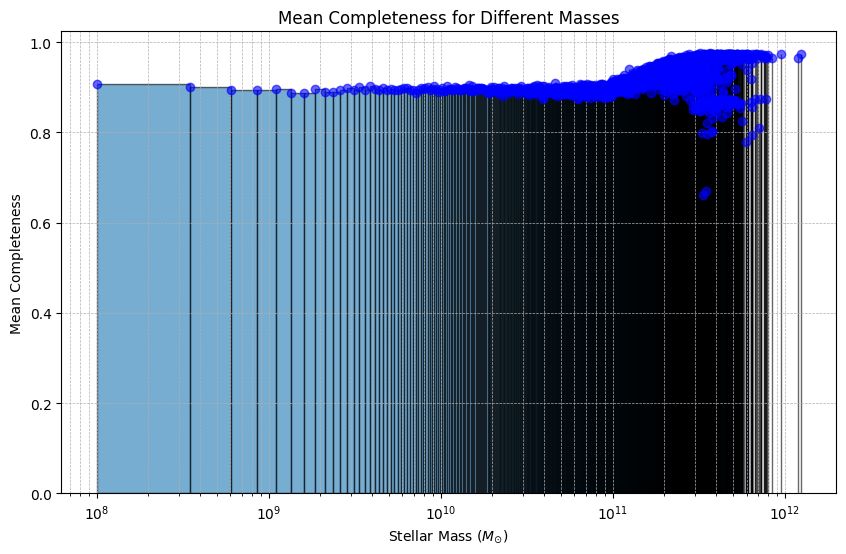

0.9749732495249364


In [20]:
# Define mass bins from min to max mstar with 1000 intervals
mass_bins = np.linspace(10**8, 10**12.1, 5000)

# Bin the data and calculate the mean completeness for each bin
bin_indices = np.digitize(full_mass_completeness_dataframe['mstar'], bins=mass_bins)
mean_completeness = [full_mass_completeness_dataframe['completeness'][bin_indices == i].mean() for i in range(1, len(mass_bins))]

# Plotting the histogram of mean completeness for different masses
plt.figure(figsize=(10, 6))
plt.plot(mass_bins[:-1], mean_completeness, alpha=0.6, color='blue', marker='o', linestyle='none')
plt.bar(mass_bins[:-1], mean_completeness, width=np.diff(mass_bins), align='edge', alpha=0.6, edgecolor='black')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot}$)')
plt.ylabel('Mean Completeness')
# plt.xlim((10**9, 10**12.5))
plt.title('Mean Completeness for Different Masses')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

# Print the maximum completeness value
print(max(mean_completeness))


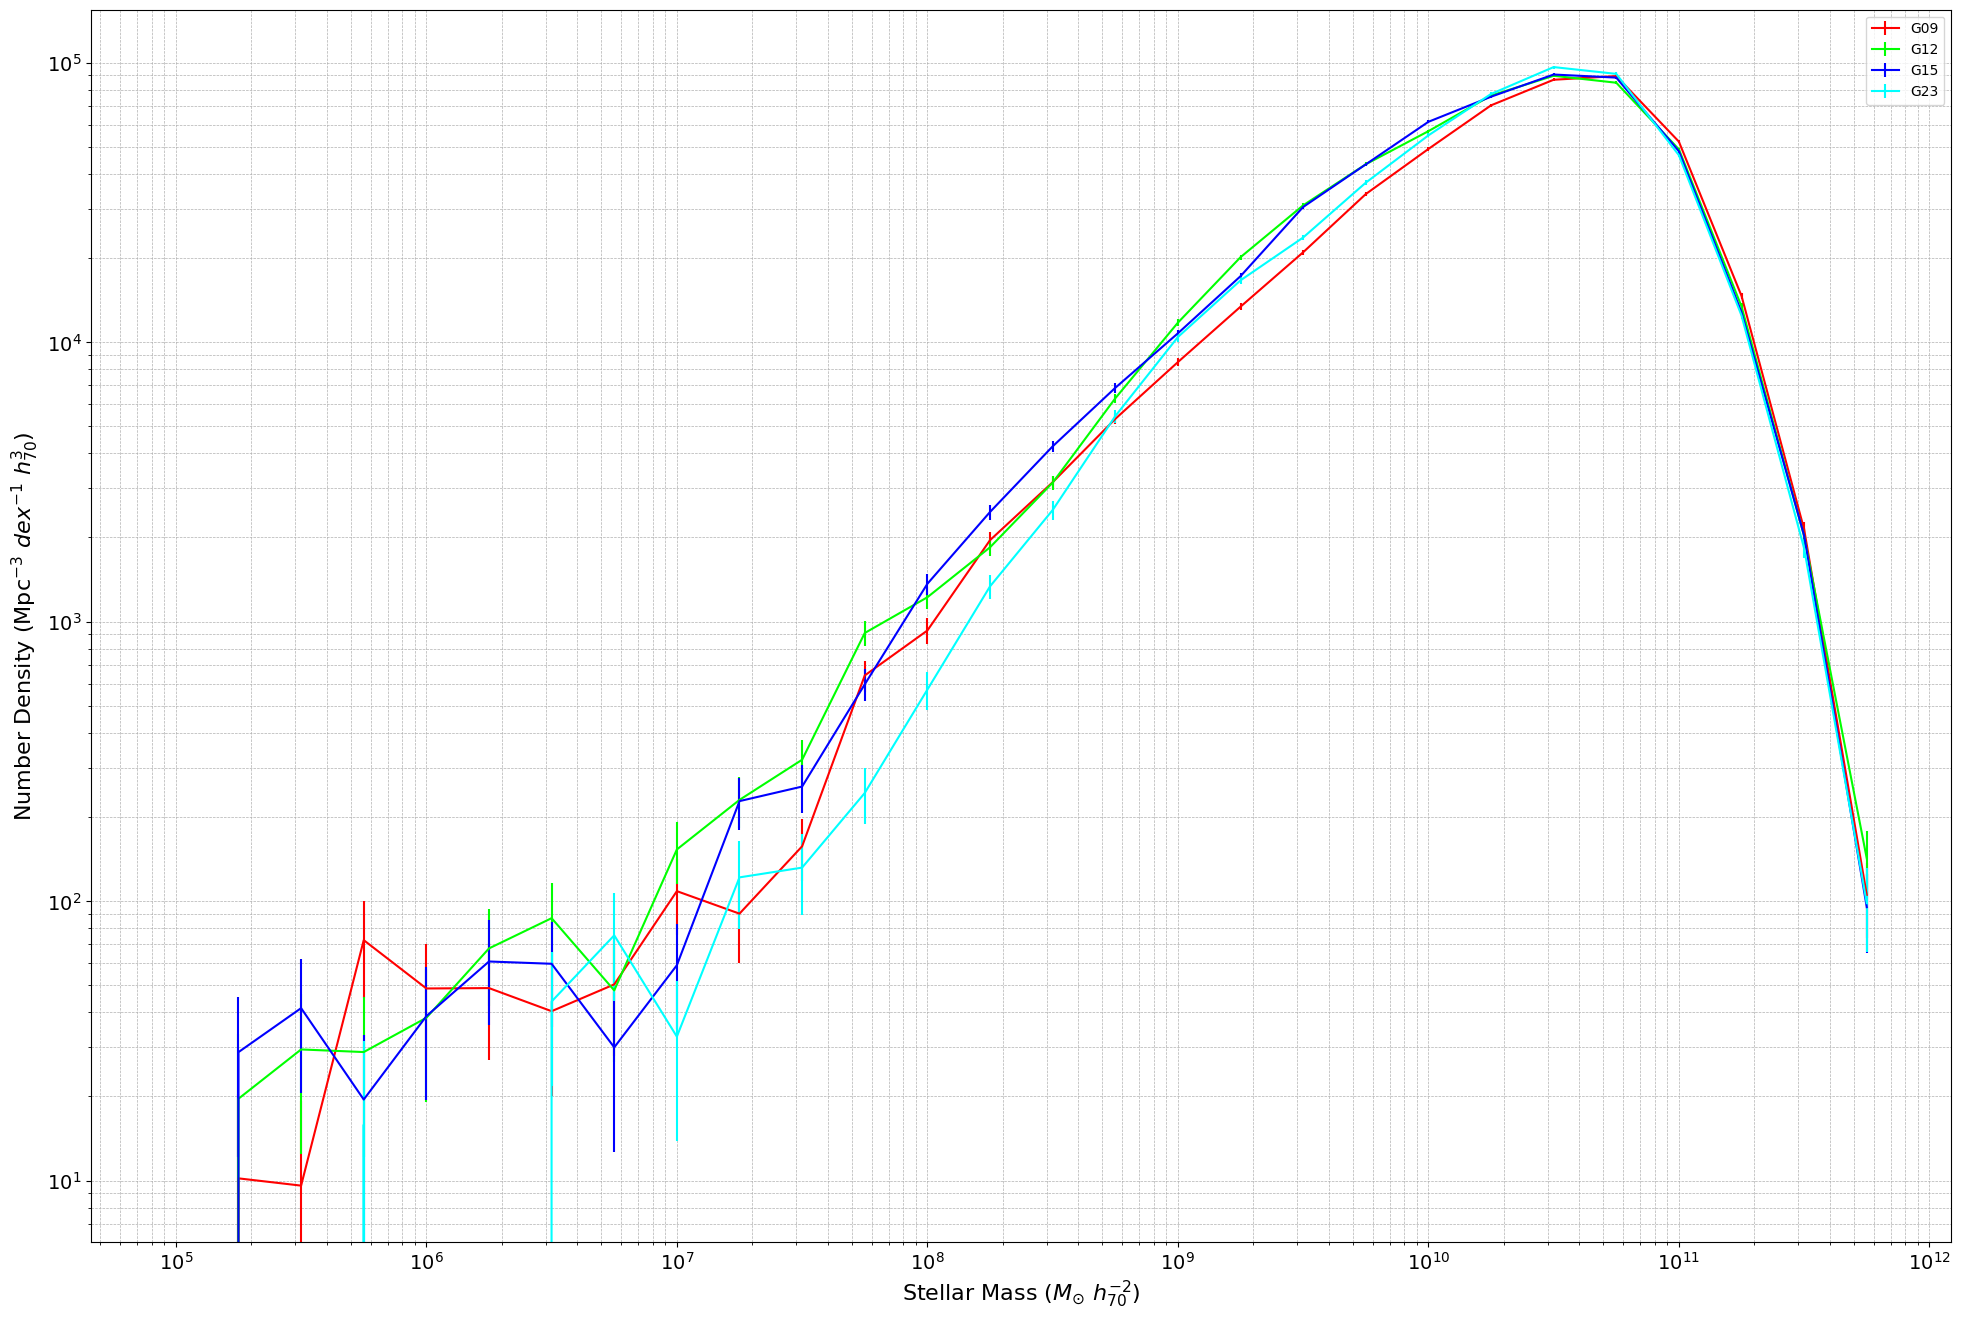

In [21]:
region_colors = {'G09': 'red', 'G12': 'lime', 'G15': 'blue', 'G23': 'cyan'}
fig, ax = plt.subplots(figsize=(24, 16))
for region_name in REGIONS_OF_SKY.keys():
    mass_hist, error = get_weighted_mass_histogram(input_mass_completeness_dataframe=full_mass_completeness_dataframe, region_name=region_name)

    plt.errorbar(
        MASS_BINS[:-1],
        mass_hist,
        yerr=error,
        label=region_name,
        color=region_colors.get(region_name),
    )

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot} \ h_{70}^{-2}$)', fontsize=16)
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ h_{70}^{3}$)', fontsize=16)
# plt.xlim((1e5, 1e12))
# plt.ylim((10**-5.7, 1e0))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()